In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/clouds-ml/src

Mounted at /content/drive
/content/drive/MyDrive/clouds-ml/src


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from config import *
df = pd.read_csv(f'{DATA_PROCESSED}/gaze.csv')
df.head()

,Observation Number,Measurement Date (UTC),Measurement Time (UTC),Observation Latitude,Observation Longitude,North Image URL,North Clearsky,North Cirrus/Cirrostratus,North Cirrocumulus/Altocumulus,North Altostratus/Stratus,...,Up Altostratus/Stratus,Up Stratocumulus,Up Cumulus,Up Cumulonimbus,Up Contrails,Up Smoke/Haze,Up Dust,Up Agreement,Up Classification Count,Up Retirement
0,116-103008-31783502-202201150147,2022-01-15,01:47:00,-40.5415,176.1947,https://data.globe.gov/system/photos/2022/01/1...,0,0,0,0,...,0,0,1,0,0,0,0,0.8,5,consensus
1,116-103110-19942096-202201151008,2022-01-15,10:08:00,60.1913,24.0056,https://data.globe.gov/system/photos/2022/01/1...,1,0,0,0,...,0,0,0,0,0,0,0,1.0,5,consensus
2,116-103334-35497537-202201152025,2022-01-15,20:25:00,40.0052,-105.1098,https://data.globe.gov/system/photos/2022/01/1...,0,1,0,0,...,0,0,0,0,0,0,0,0.8,5,consensus
3,116-103334-35497537-202201161722,2022-01-16,17:22:00,40.0051,-105.1098,https://data.globe.gov/system/photos/2022/01/1...,0,1,0,0,...,0,0,0,0,0,0,0,1.0,5,consensus
4,116-103334-35497537-202201161916,2022-01-16,19:16:00,40.0053,-105.1095,https://data.globe.gov/system/photos/2022/01/1...,0,0,0,0,...,0,0,0,0,0,0,0,0.4,8,classification_count


In [ ]:
print(df.columns)

Index(['Observation Number', 'Measurement Date (UTC)',
       'Measurement Time (UTC)', 'Observation Latitude',
       'Observation Longitude', 'North Image URL', 'North Clearsky',
       'North Cirrus/Cirrostratus', 'North Cirrocumulus/Altocumulus',
       'North Altostratus/Stratus', 'North Stratocumulus', 'North Cumulus',
       'North Cumulonimbus', 'North Contrails', 'North Smoke/Haze',
       'North Dust', 'North Agreement', 'North Classification Count',
       'North Retirement', 'East Image URL', 'East Clearsky',
       'East Cirrus/Cirrostratus', 'East Cirrocumulus/Altocumulus',
       'East Altostratus/Stratus', 'East Stratocumulus', 'East Cumulus',
       'East Cumulonimbus', 'East Contrails', 'East Smoke/Haze', 'East Dust',
       'East Agreement', 'East Classification Count', 'East Retirement',
       'South Image URL', 'South Clearsky', 'South Cirrus/Cirrostratus',
       'South Cirrocumulus/Altocumulus', 'South Altostratus/Stratus',
       'South Stratocumulus', 'South C

In [ ]:
# cloud_gaze_flatten.py

import os
import re
import time
import math
import hashlib
import pathlib
from typing import Optional, Dict, List
from tqdm.auto import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np
import requests

from config import *

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

DIRECTIONS = ["North", "East", "South", "West", "Up"]

LABEL_COL_MAP = {
    "Clearsky": "clearsky",
    "Cirrus/Cirrostratus": "cirrus_cirrostratus",
    "Cirrocumulus/Altocumulus": "cirrocumulus_altocumulus",
    "Altostratus/Stratus": "altostratus_stratus",
    "Stratocumulus": "stratocumulus",
    "Cumulus": "cumulus",
    "Cumulonimbus": "cumulonimbus",
    "Contrails": "contrails",
    "Smoke/Haze": "smoke_haze",
    "Dust": "dust",  # ensure dust is included
}

GLOBAL_META = {
    "Observation Number": "observation_number",
    "Measurement Date (UTC)": "measurement_date_utc",
    "Measurement Time (UTC)": "measurement_time_utc",
    "Observation Latitude": "latitude",
    "Observation Longitude": "longitude",
}

PER_IMAGE_META = {
    "Agreement": "agreement",
    "Classification Count": "classification_count",
    "Retirement": "retirement",
}

def _coalesce_date_time(date_str, time_str):
    if (date_str is None or str(date_str).strip()=="") and (time_str is None or str(time_str).strip()==""):
        return None
    ts = pd.to_datetime(f"{date_str} {time_str}".strip(), utc=True, errors="coerce")
    return None if pd.isna(ts) else ts

def _safe_filename_from_url(url: str) -> str:
    import hashlib, re
    h = hashlib.sha256(url.encode("utf-8")).hexdigest()[:16]
    m = re.search(r"\.(jpg|jpeg|png|webp|gif|bmp|tiff?)($|\?)", url, re.IGNORECASE)
    ext = ("." + m.group(1).lower()) if m else ".jpg"
    return f"{h}{ext}"

def _download_image(url: str, out_dir: pathlib.Path, max_retries: int = 3, timeout: int = 15):
    out_dir.mkdir(parents=True, exist_ok=True)
    fpath = out_dir / _safe_filename_from_url(url)
    if fpath.exists() and fpath.stat().st_size > 0:
        return str(fpath)
    for attempt in range(1, max_retries+1):
        try:
            r = requests.get(url, timeout=timeout, stream=True)
            if r.status_code == 200 and "image" in r.headers.get("content-type",""):
                with open(fpath, "wb") as fh:
                    for chunk in r.iter_content(8192):
                        if chunk: fh.write(chunk)
                return str(fpath)
        except Exception:
            pass
        time.sleep(0.8*attempt)
    return None

def flatten_cloud_gaze(
    df: pd.DataFrame,
    download_dir: Optional[str] = None,
    download_limit: Optional[int] = None,
    use_tqdm: bool = True,
    drop_not_classified: bool = False,  # set True to remove images where all 10 labels were 5
) -> pd.DataFrame:
    long_rows = []
    directions_iter = tqdm(DIRECTIONS, desc="Processing directions") if use_tqdm else DIRECTIONS

    for direction in directions_iter:
        dir_url_col = f"{direction} Image URL"
        if dir_url_col not in df.columns:
            continue

        # build per-direction maps
        dir_label_cols = {f"{direction} {raw}": uni for raw, uni in LABEL_COL_MAP.items() if f"{direction} {raw}" in df.columns}
        dir_meta_cols  = {f"{direction} {raw}": uni for raw, uni in PER_IMAGE_META.items() if f"{direction} {raw}" in df.columns}

        keep_cols = [dir_url_col] + list(dir_label_cols.keys()) + list(dir_meta_cols.keys()) + list(GLOBAL_META.keys())
        sub = df[[c for c in keep_cols if c in df.columns]].copy()

        # rename & tag
        sub = sub.rename(columns={dir_url_col: "photo_url", **dir_label_cols, **dir_meta_cols, **GLOBAL_META})
        sub["direction"] = direction.lower()

        # ensure all unified label cols exist in this slice
        for uni in LABEL_COL_MAP.values():
            if uni not in sub.columns:
                sub[uni] = np.nan

        # --- handle the 0/1/5 semantics ---
        label_cols = list(LABEL_COL_MAP.values())

        # normalize common oddities (e.g., 'X' -> 1) *before* numeric coercion
        sub[label_cols] = sub[label_cols].replace({"X":1, "x":1, "TRUE":1, "True":1, "true":1})

        # numeric view for 5-detection
        vals_num = sub[label_cols].apply(pd.to_numeric, errors="coerce")

        # not_classified: all ten category columns are exactly 5 for this image
        sub["not_classified"] = (vals_num.eq(5).all(axis=1)).astype(int)

        # binarize labels: 1->1, 0->0, 5->0, others/NaN->0
        vals_num = vals_num.replace(5, 0).fillna(0).clip(lower=0, upper=1)
        sub[label_cols] = vals_num.astype(int)

        # per-image metadata
        if "agreement" in sub.columns:
            sub["agreement"] = pd.to_numeric(sub["agreement"], errors="coerce")
        if "classification_count" in sub.columns:
            sub["classification_count"] = pd.to_numeric(sub["classification_count"], errors="coerce")

        # globals
        sub["measurement_datetime_utc"] = [
            _coalesce_date_time(d, t) for d, t in zip(sub.get("measurement_date_utc"), sub.get("measurement_time_utc"))
        ]
        sub["latitude"]  = pd.to_numeric(sub.get("latitude"), errors="coerce")
        sub["longitude"] = pd.to_numeric(sub.get("longitude"), errors="coerce")
        sub = sub.drop(columns=[c for c in ["measurement_date_utc","measurement_time_utc"] if c in sub.columns])

        # drop rows with no URL
        sub = sub[~sub["photo_url"].isna() & (sub["photo_url"].astype(str).str.strip()!="")]

        long_rows.append(sub)

    if not long_rows:
        raise ValueError("No directional rows found; check column names.")

    out = pd.concat(long_rows, ignore_index=True)

    # Optionally remove the 'not_classified' images
    if drop_not_classified:
        out = out[out["not_classified"] == 0].reset_index(drop=True)

    # Optional downloads
    if download_dir is not None:
        dl_dir = pathlib.Path(download_dir)
        urls = out["photo_url"].tolist()
        iterator = tqdm(urls, desc="Downloading images", total=len(urls)) if use_tqdm else urls
        local_paths, successes = [], 0
        for url in iterator:
            if download_limit is not None and successes >= download_limit:
                local_paths.append(None); continue
            lp = _download_image(url, dl_dir)
            successes += int(lp is not None)
            local_paths.append(lp)
        out["local_path"] = local_paths

    # order columns
    label_cols = list(LABEL_COL_MAP.values()) + ["not_classified"]
    ordered = (
        ["observation_number","direction","photo_url"]
        + (["local_path"] if "local_path" in out.columns else [])
        + ["measurement_datetime_utc","latitude","longitude","agreement","classification_count"]
        + label_cols
    )
    existing = [c for c in ordered if c in out.columns]
    remaining = [c for c in out.columns if c not in existing]
    return out[existing + remaining]



RAW_CSV = f"{DATA_PROCESSED}/cloud_gaze_raw.csv"            # your original export
OUTPUT_CSV = f"{DATA_PROCESSED}/cloud_gaze_flat.csv"        # flattened output
DOWNLOAD_DIR = f"{BASE_DIR}/data/cloud_gaze_images"             # set to None to skip downloads
DOWNLOAD_LIMIT = None                     # e.g., 500 during testing

raw_df = pd.read_csv(RAW_CSV)
flat_df = flatten_cloud_gaze(raw_df, download_dir=DOWNLOAD_DIR, download_limit=DOWNLOAD_LIMIT)

print(f"Flattened rows: {len(flat_df):,}")
print("Label prevalence:")
label_cols = list(LABEL_COL_MAP.values())
print(flat_df[label_cols].sum().sort_values(ascending=False))

flat_df.to_csv(OUTPUT_CSV, index=False)
print(f"Wrote {OUTPUT_CSV}")


Processing directions:   0%|          | 0/5 [00:00<?, ?it/s]

Flattened rows: 13,500
Label prevalence:
clearsky                    4363
altostratus_stratus         3311
cumulus                     1636
cirrus_cirrostratus         1405
stratocumulus                658
cirrocumulus_altocumulus     556
cumulonimbus                 231
dust                          19
contrails                      0
smoke_haze                     0
dtype: int64
Wrote /content/drive/MyDrive/clouds-ml/data/processed/cloud_gaze_flat.csv


In [ ]:
df = pd.read_csv(f'{DATA_PROCESSED}/cloud_gaze_flat.csv')
df.head(20)

,observation_number,direction,photo_url,local_path,measurement_datetime_utc,latitude,longitude,agreement,classification_count,clearsky,...,cirrocumulus_altocumulus,altostratus_stratus,stratocumulus,cumulus,cumulonimbus,contrails,smoke_haze,dust,not_classified,retirement
0,116-103008-31783502-202201150147,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-15 01:47:00+00:00,-40.5415,176.1947,0.5,8,0,...,0,0,0,1,0,0,0,0,0,classification_count
1,116-103110-19942096-202201151008,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-15 10:08:00+00:00,60.1913,24.0056,1.0,5,1,...,0,0,0,0,0,0,0,0,0,consensus
2,116-103334-35497537-202201152025,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-15 20:25:00+00:00,40.0052,-105.1098,0.8,8,0,...,0,0,0,0,0,0,0,0,0,classification_count
3,116-103334-35497537-202201161722,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-16 17:22:00+00:00,40.0051,-105.1098,1.0,5,0,...,0,0,0,0,0,0,0,0,0,consensus
4,116-103334-35497537-202201161916,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-16 19:16:00+00:00,40.0053,-105.1095,0.4,8,0,...,0,0,0,0,1,0,0,0,0,classification_count
5,116-103334-35497537-202201171805,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-17 18:05:00+00:00,40.0050,-105.1098,0.4,8,0,...,1,0,0,0,0,0,0,0,0,classification_count
6,116-103334-35497537-202201171901,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-17 19:01:00+00:00,40.0053,-105.1094,0.2,8,0,...,0,0,0,1,0,0,0,0,0,classification_count
7,116-103334-35497537-202201181710,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-18 17:10:00+00:00,40.0052,-105.1098,0.5,8,0,...,0,1,0,0,0,0,0,0,0,classification_count
8,116-103334-35497537-202201182041,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-18 20:41:00+00:00,40.0051,-105.1097,0.6,8,0,...,0,1,0,0,0,0,0,0,0,classification_count
9,116-106827-80972583-202201170413,north,https://data.globe.gov/system/photos/2022/01/1...,/content/drive/MyDrive/clouds-ml/data/cloud_ga...,2022-01-17 04:13:00+00:00,24.1056,120.6360,0.8,5,0,...,0,1,0,0,0,0,0,0,0,consensus


In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def sample_df_subs(
    df,
    n=4,
    cloud_cols=None,
    local_col="local_path",
    url_col="photo_url",
    fallback_to_url=True
):
    """
    Show a grid of sample images with their labels.

    Args:
        df : pandas.DataFrame
        n  : grid dimension (n x n)
        cloud_cols : list of label column names
        local_col : column with local file paths
        url_col : column with URLs (used if fallback_to_url=True)
        fallback_to_url : if True, try downloading image if local path is missing
    """
    if cloud_cols is None:
        raise ValueError("Must pass cloud_cols (list of one-hot label columns)")

    sample_size = min(n * n, len(df))
    sample = df.sample(sample_size)

    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample.iterrows()):
        img = None

        # Try local path
        if local_col in row and pd.notna(row[local_col]) and os.path.exists(str(row[local_col])):
            try:
                img = Image.open(row[local_col]).convert("RGB")
            except Exception:
                img = None

        # Fallback to URL
        # if img is None and fallback_to_url and url_col in row and pd.notna(row[url_col]):
        #     try:
        #         r = requests.get(row[url_col], timeout=10)
        #         if r.status_code == 200:
        #             img = Image.open(BytesIO(r.content)).convert("RGB")
        #     except Exception:
        #         img = None

        # If still None, skip
        if img is not None:
            ax.imshow(img)
            labels = [c for c in cloud_cols if c in row and row[c] == 1]
            ax.set_title(", ".join(labels), fontsize=7)
        else:
            ax.set_facecolor("lightgray")
            ax.set_title("missing", fontsize=7)

        ax.axis("off")

    for ax in axes[len(sample):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

def df_corr_matrix(df, cloud_cols=CLOUD_COLS):
    corr = df[cloud_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Correlation matrix of cloud types for a df")
    plt.show()

    # return corr

def df_imgs_per_cloud(df, cloud_cols=CLOUD_COLS):
    label_counts = df[CLOUD_COLS].sum()
    plt.figure(figsize=(10,5))
    label_counts.plot(kind="bar")
    plt.title("Number of images per cloud type")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

def df_labels_per_img(df, cloud_cols=CLOUD_COLS):
    df["num_labels"] = df[CLOUD_COLS].sum(axis=1)
    df["num_labels"].value_counts().sort_index().plot(kind="bar")
    plt.title("Number of labels per image")
    plt.xlabel("# of labels")
    plt.ylabel("Count")
    plt.show()
    print(f"Mean number of labels: {df['num_labels'].mean()}")

def conditional_prob(df, A, B):
    A_present = df[df[A] == 1]
    if len(A_present) == 0:
        return 0
    return (A_present[B] == 1).mean()

def df_cond_prob_matrix(df, cloud_cols=CLOUD_COLS):
    cond_probs = pd.DataFrame(index=CLOUD_COLS, columns=CLOUD_COLS, dtype=float)

    for A in CLOUD_COLS:
        for B in CLOUD_COLS:
            cond_probs.loc[A, B] = conditional_prob(df, A, B)

    plt.figure(figsize=(10,8))
    sns.heatmap(cond_probs, annot=True, cmap="Greens")
    plt.title("Conditional probability matrix P(col|row)")
    plt.show()

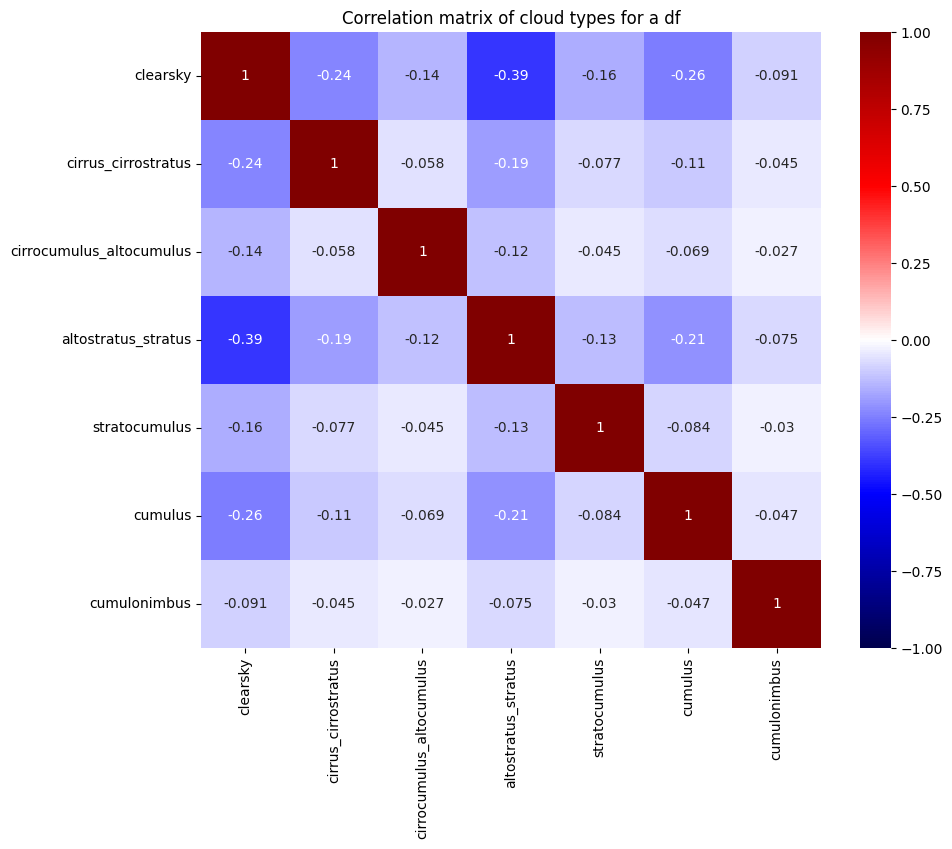

In [ ]:
df_corr_matrix(df)

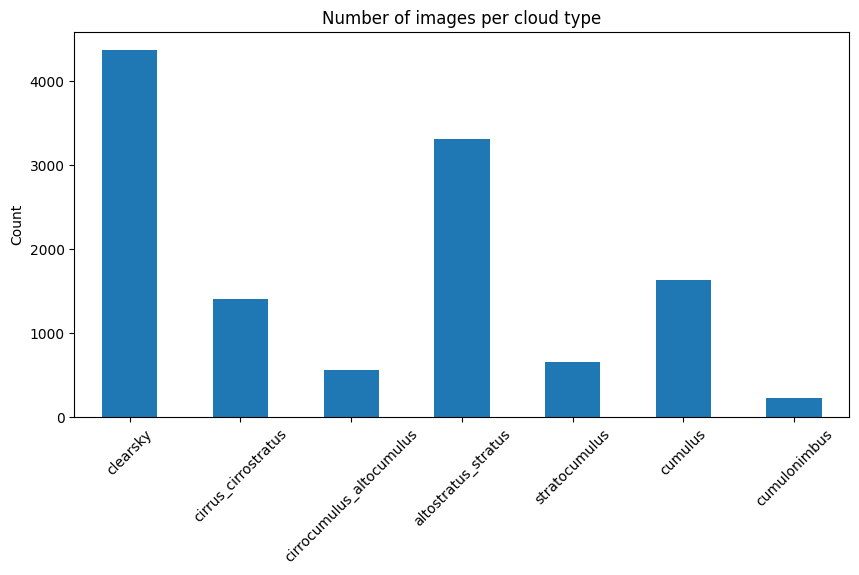

In [ ]:
df_imgs_per_cloud(df)

In [ ]:
CLOUD_COLS = [
  "clearsky",
  "cirrus_cirrostratus",
  "cirrocumulus_altocumulus",
  "altostratus_stratus",
  "stratocumulus",
  "cumulus",
  "cumulonimbus",
  "not_classified"
]

print("Label prevalence:")
print(df[CLOUD_COLS].sum().sort_values(ascending=False))

# other = df[df['cumulus'] == 1]
# sample_df_subs(other, cloud_cols=CLOUD_COLS)

Label prevalence:
clearsky                    4363
altostratus_stratus         3311
cumulus                     1636
cirrus_cirrostratus         1405
not_classified              1026
stratocumulus                658
cirrocumulus_altocumulus     556
cumulonimbus                 231
dtype: int64
